In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
import matplotlib.pyplot as plt

In [2]:
tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY', 'GOOGl']  # Example tickers
start_date = '2013-01-01'
end_date = '2019-01-01'
data = yf.download(tickers, start=start_date, end=end_date)['Close']

[*********************100%%**********************]  12 of 12 completed


In [3]:
data.head()

Ticker,AAPL,ADBE,AMD,EBAY,GOOGL,HPQ,IBM,JNPR,MSFT,ORCL,QCOM,SPY
Date,,,,,,,,,,,,
2013-01-02,19.608213,38.340000,2.53,22.554714,18.099348,6.821072,187.715103,20.549999,27.620001,34.689999,64.750000,146.059998
2013-01-03,19.360714,37.750000,2.49,22.074917,18.109859,6.875568,186.682602,20.170000,27.250000,34.310001,64.449997,145.729996
2013-01-04,18.821428,38.130001,2.59,22.213804,18.467718,6.875568,185.458893,20.379999,26.740000,34.610001,63.500000,146.369995
2013-01-07,18.710714,37.939999,2.67,22.521044,18.387136,6.889192,184.646271,20.150000,26.690001,34.430000,64.010002,145.970001
2013-01-08,18.761070,38.139999,2.67,22.171717,18.350851,6.989101,184.388138,19.719999,26.549999,34.439999,63.910000,145.550003


In [4]:
# # Step 2: Calculate Pairwise Cointegration using Engle-Granger test

# # Implementation of Linear Regression

# def linear_regression(y, X):

#     y = np.array(y)
#     X = np.array(X)
#     # Step 1: Calculate means of y and X
#     mean_y = np.mean(y)
#     mean_X = np.mean(X)
    
#     # Step 2: Calculate standard deviations of y and X
#     std_y = np.std(y)
#     std_X = np.std(X)
    
#     # Step 3: Calculate coefficient of correlation
#     correlation_coeff = np.corrcoef(X, y)[0, 1]
    
#     # Step 4: Calculate coefficient of regression using the formula
#     coeff_regression = correlation_coeff * (std_y / std_X)
    
#     # Step 5: Calculate intercept using the formula: intercept = mean_y - coeff_regression * mean_X
#     intercept = mean_y - coeff_regression * mean_X
    
#     # Step 6: Calculate predicted y values
#     y_predicted = intercept + coeff_regression * X
    
#     # Step 7: Calculate residuals
#     residuals = y - y_predicted
    
#     return residuals, coeff_regression, intercept


# # Implementing ADF test:
# def adf_test(residuals):  # Adjust significance level
#     result = adfuller(residuals)
#     adf_statistic = result[0]
#     p_value = result[1]
#     return adf_statistic, p_value


# # Implementing Engle-Granger Cointegration


# def engle_granger_coint(y1, y2):
#     # Step 1: Perform linear regression
#     residuals, _, _ = linear_regression(y1, y2)

#     # Step 2: Perform ADF test on residuals
#     adf_statistic, p_value = adf_test(residuals)

#     # Step 3: Check for cointegration
#     if p_value < 0.05:  # Assuming 10% significance level
#         return True, adf_statistic, p_value 
#     else:
#         return False, adf_statistic, p_value
    





from sklearn.linear_model import LinearRegression

def adf_test(series):
    result = adfuller(series,autolag='AIC', regression='c')
    return result[0], result[1]  # adf_statistic, p_value, critical_values

def check_stationarity(series, significance=0.05):
    result = adfuller(series, autolag='AIC', regression='c')
    adf_statistic = result[0]
    p_value = result[1]
    
    is_stationary = p_value < significance

    return is_stationary

def linear_regression(y, X):

    # y = np.array(y)
    # X = np.array(X)
    
    # mean_y = np.mean(y)
    # mean_X = np.mean(X)
  
    # std_y = np.std(y)
    # std_X = np.std(X)
    
    # correlation_coeff = np.corrcoef(X, y)[0, 1]
    
    # coeff_regression = correlation_coeff * (std_y / std_X)
    
    # intercept = mean_y - coeff_regression * mean_X
    
    # y_predicted = intercept + coeff_regression * X
    
    # residuals = y - y_predicted
    
    # return residuals, coeff_regression, intercept

    X = np.array(X).reshape(-1, 1)  # Reshape for sklearn
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
        
    residuals = y - model.predict(X)
    coefficient = model.coef_[0]
    intercept = model.intercept_
        
    return residuals, coefficient, intercept

def engle_granger_coint(y1, y2, significance=0.05):
    # Step 1: Check if both series are I(1)
    # print("Checking stationarity of series...")
    if check_stationarity(y1, significance) or check_stationarity(y2, significance):
        # print("Error: One or both series are stationary. They must be I(1) for cointegration.")
        return False
    
    # Check if first differences are stationary
    if not (check_stationarity(np.diff(y1), significance) and 
            check_stationarity(np.diff(y2), significance)):
        # print("Error: First differences are not stationary. Series must be I(1).")
        return False
    
    # Step 2: Perform linear regression (both directions)
    residuals1, coef1, intercept1 = linear_regression(y1, y2)
    residuals2, coef2, intercept2 = linear_regression(y2, y1)
    
    # Step 3: Perform ADF test on residuals (both directions)
    _, p_value1  = adf_test(residuals1)
    _, p_value2 = adf_test(residuals2)
    
    # Step 4: Check for cointegration
    is_coint1 = p_value1 < significance
    is_coint2 = p_value2 < significance
    
    return is_coint1 and is_coint2

In [5]:
# Step 3: Calculate Pairwise Cointegration using Engle-Granger test

# def find_cointegrated_pairs(data, significance=0.05):
#     n = data.shape[1]
#     score_matrix = np.zeros((n, n))
#     pvalue_matrix = np.ones((n, n))
#     keys = data.keys()
#     pairs = []
#     for i in range(n):
#         for j in range(i+1, n):
#             S1 = data[keys[i]]
#             S2 = data[keys[j]]
#             result = coint(S1, S2)
#             score = result[0]
#             pvalue = result[1]
#             score_matrix[i, j] = score
#             pvalue_matrix[i, j] = pvalue
#             # is_cointegrated = engle_granger_coint(S1, S2)
#             is_cointegrated = pvalue < significance
#             if is_cointegrated:
#                 pairs.append((keys[i], keys[j]))
#     return score_matrix, pvalue_matrix, pairs

def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            
            is_cointegrated = engle_granger_coint(S1, S2) and engle_granger_coint(S2, S1)
            
            # Storing results of Engle-Granger cointegration test
            if is_cointegrated:
                pairs.append((keys[i], keys[j]))
                
                # Use linear regression residuals to compute score and p-value for consistency
                residuals, _, _ = linear_regression(S1, S2)
                adf_stat, pvalue = adf_test(residuals)
                score_matrix[i, j] = adf_stat
                pvalue_matrix[i, j] = pvalue
                
                # Also compute for reverse direction for completeness
                residuals, _, _ = linear_regression(S2, S1)
                adf_stat, pvalue = adf_test(residuals)
                score_matrix[j, i] = adf_stat
                pvalue_matrix[j, i] = pvalue
            else:
                # Fill score and p-value matrices with NaNs or zeros for non-cointegrated pairs
                score_matrix[i, j] = np.nan
                pvalue_matrix[i, j] = 1.0
                score_matrix[j, i] = np.nan
                pvalue_matrix[j, i] = 1.0
    
    return score_matrix, pvalue_matrix, pairs


[('AAPL', 'HPQ'), ('AAPL', 'ORCL'), ('AAPL', 'SPY'), ('ADBE', 'AMD'), ('ADBE', 'MSFT'), ('AMD', 'MSFT'), ('HPQ', 'ORCL'), ('IBM', 'JNPR'), ('ORCL', 'SPY')]


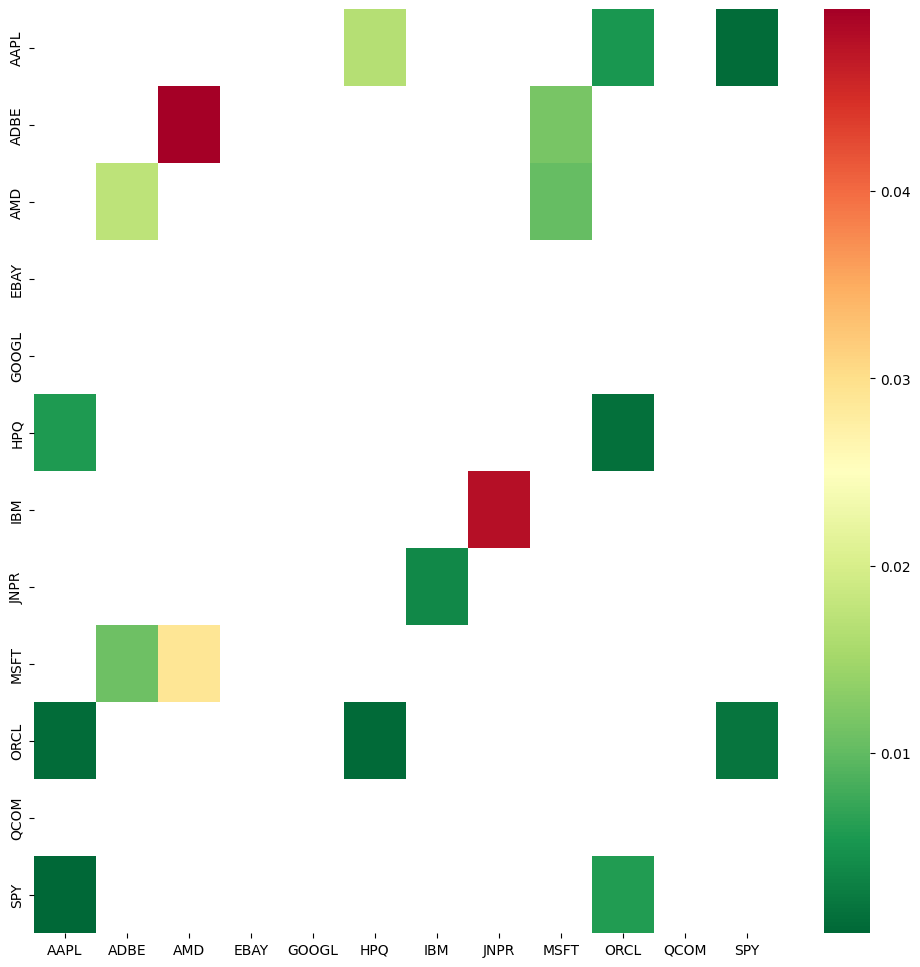

In [6]:
scores, pvalues, pairs = find_cointegrated_pairs(data)
# seaborn
fig, ax = plt.subplots(figsize=(12,12))
seaborn.heatmap(pvalues, xticklabels=data.columns, yticklabels=data.columns, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.05)
                )
print(pairs)

In [7]:
S1 = data['AAPL']
S2 = data['HPQ']

# Check cointegration using custom Engle-Granger cointegration test
is_coint_custom = engle_granger_coint(S1, S2)
print(is_coint_custom)


True


In [8]:
score, p_value, _ = coint(data['AAPL'], data['HPQ'])
print(f'Cointegration test p-value: {p_value}')

Cointegration test p-value: 0.059863937571366425


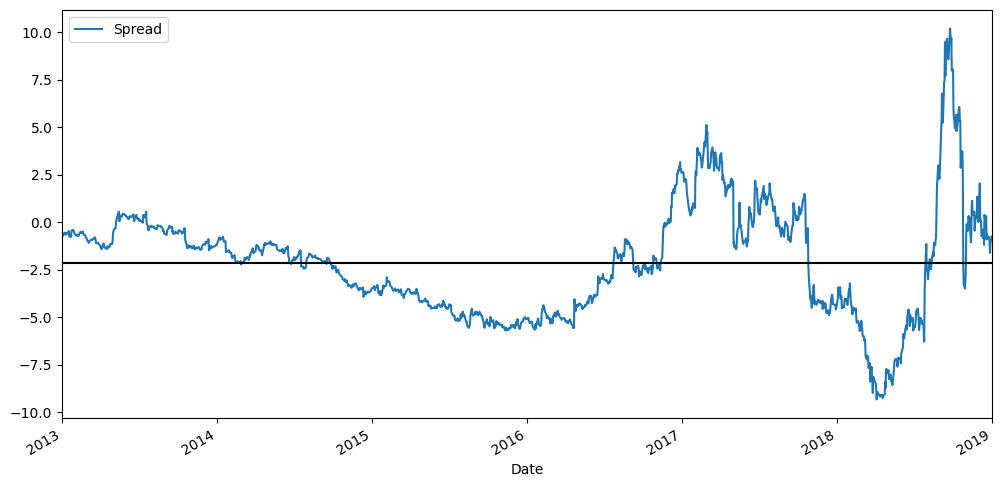

In [143]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['AAPL']
b = results.params['AAPL']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2013-01-01', '2019-01-01')
plt.legend(['Spread']);

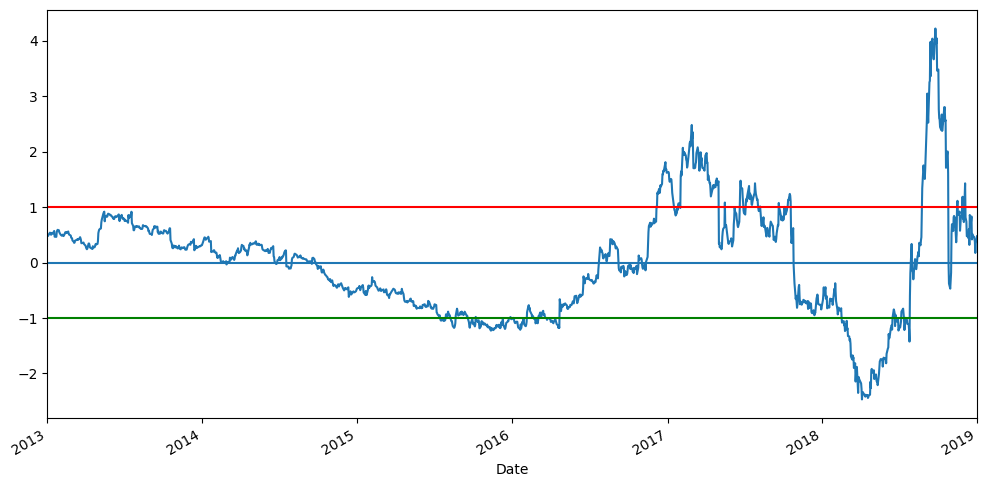

In [144]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(spread).plot(figsize=(12,6))
plt.axhline(zscore(spread).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2013-01-01', '2019-01-01')
plt.show()

In [145]:
ratios = data['ADBE'] / data['AMD'] 
print(len(ratios) * .70 ) 

1057.0


In [146]:
train = ratios[:1057]
test = ratios[1057:]

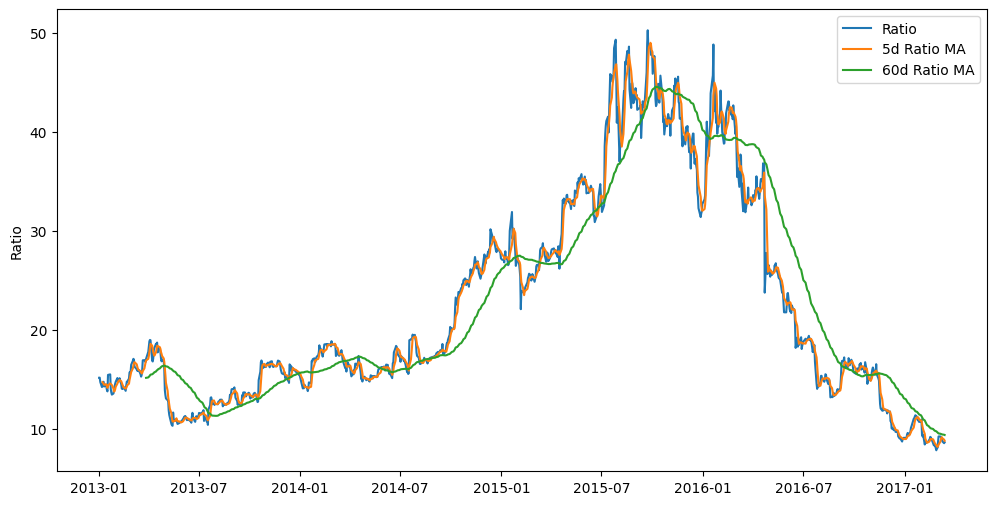

In [147]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

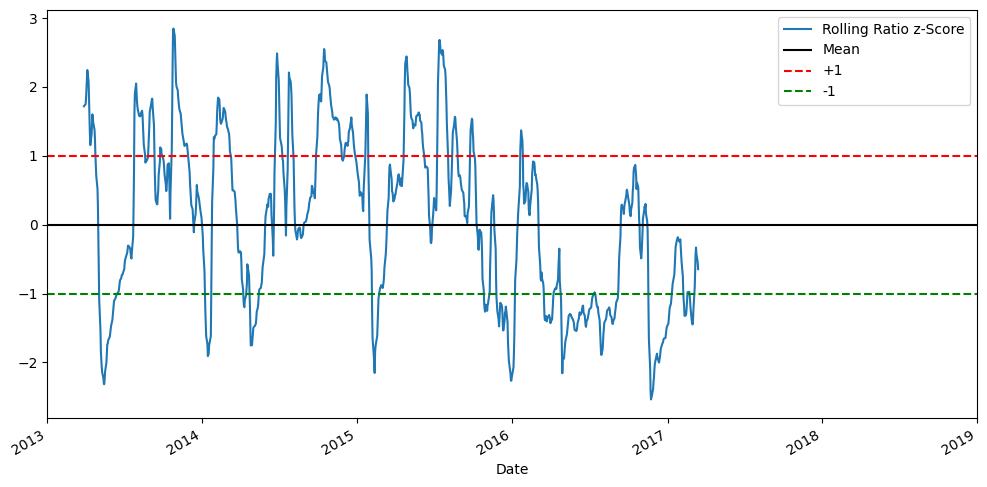

In [148]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.xlim('2013-01-01', '2019-01-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

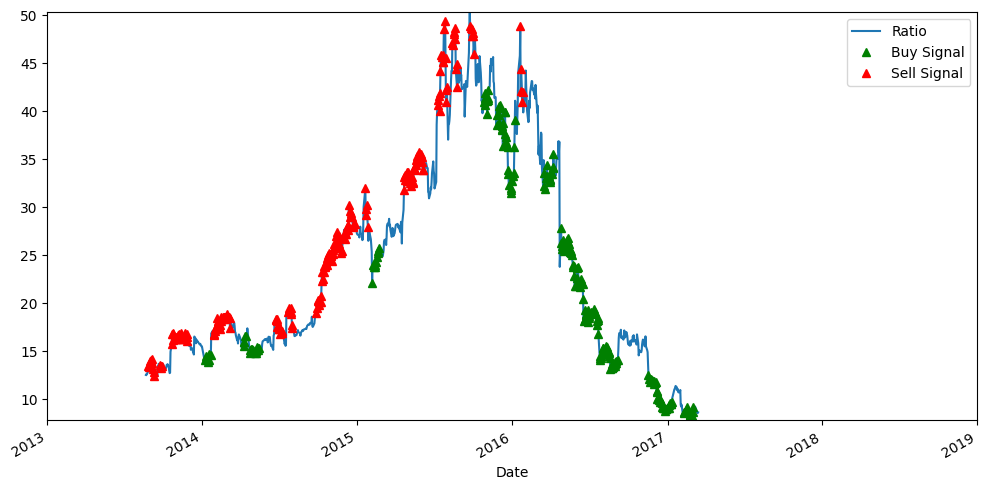

In [149]:
plt.figure(figsize=(12,6))

train[160:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.xlim('2013-01-01','2019-01-01')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

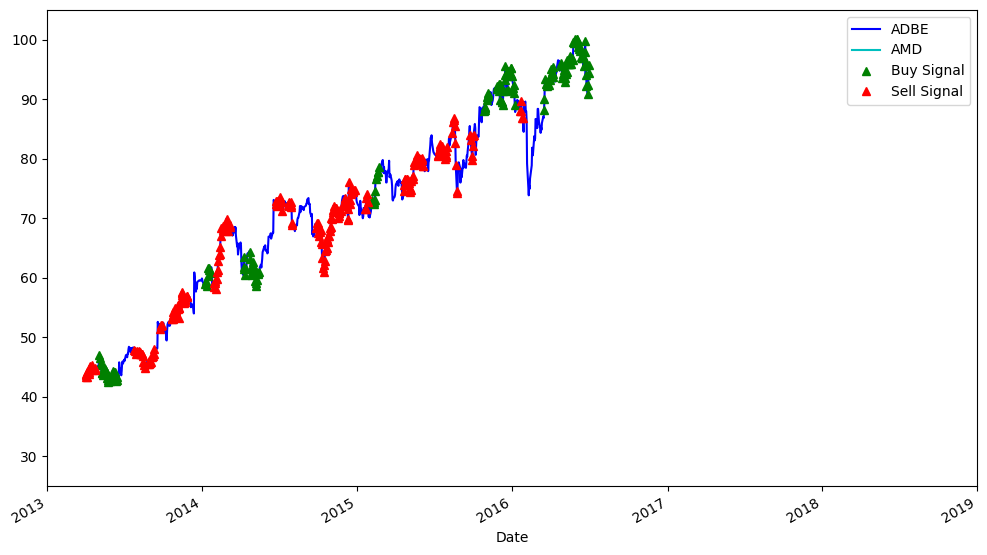

In [150]:
plt.figure(figsize=(12,7))
S1 = data['ADBE'].iloc[:881]
S2 = data['AMD'].iloc[:881]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(25, 105)
plt.xlim('2013-01-01', '2019-01-01')

plt.legend(['ADBE', 'AMD', 'Buy Signal', 'Sell Signal'])
plt.show()